## This notebook is used to test out in house algorithms on simulated chromatograms

**Feel free to do anything with this notebook Emery! I will work on *01_convolutional_neural_network***

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../src/')

from cnn.simulator import Simulator

from savgol.utils import savgol_filter
from savgol.utils import asymmetric_least_squares
from savgol.utils import durbin_watson_criterion
from savgol.utils import find_peaks
from savgol.utils import rescale_deriv

In [5]:
simulator = Simulator(
    resolution=16384,
    num_peaks_range=(10, 50),
    snr_range=(10.0, 45.0),
    amplitude_range=(5, 250),
    loc_range=(0.05, 0.95),
    scale_range=(0.001, 0.003),
    asymmetry_range=(-0.15, 0.15),
    baseline_drift_magnitude=(-0, 0),
    noise_type='white',
)

## Part 1: Peak detection (by Emery)

In [6]:
def scale(arr):
    '''
    Rescales inputted array by dividing arr with max(abs(arr))
    '''
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)
        
    return arr / np.max(np.abs(arr))
    
    
def find_local_minima(arr, thresh):
    '''
    Finds local minima in second derivative. In the ideal case,
    local minima should correspond to the peak apices.
    '''
    minima = []
    for i in range(len(arr)-7):
        if arr[i+4] < arr[i] and arr[i+4] < arr[i+1] and arr[i+4] < arr[i+2] and arr[i+4] < arr[i+3] and arr[i+4] < arr[i+5] and arr[i+4] < arr[i+6] and arr[i+4] < arr[i+7] and arr[i+4] < -thresh:
            minima.append(i+4)
    return minima


13
[1471, 1924, 3292, 3372, 6519, 6842, 7253, 8603, 9675, 11632, 13592, 14811, 14929]
15
[1470, 1924, 3296, 3372, 6519, 6841, 7250, 8603, 9677, 11633, 12413, 13593, 14644, 14812, 14925]


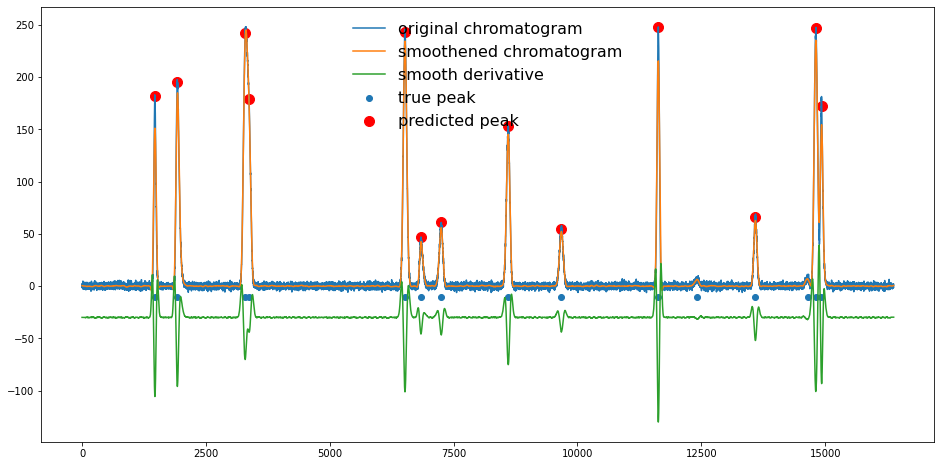

In [9]:
plt.figure(figsize=(16, 8))

data = simulator._generate(4)
x = data['chromatogram']

# Lets use big window size for better peak detection
x_smooth, x_deriv = savgol_filter(x, window_length=101, deriv=2)
x_deriv = scale(x_deriv)

# Finding peaks with in-house code 
loc = find_local_minima(scale(x_deriv), 0.05)

# Find peaks by finding the local minima in the second derivative
print(len(loc))
print(loc)

# Plot out stuff
plt.plot(x, label='original chromatogram')
plt.plot(x_smooth, label='smoothened chromatogram')
plt.scatter(data['loc']*len(x), [-10.]*len(data['loc']), label='true peak')
p = (data['loc']*len(x)).tolist()
p.sort()
peaks = []
for i in p:
    peaks.append(int(i))
print(len(peaks))
print(peaks)
plt.scatter(loc, x[loc], color='red', s=100, label='predicted peak')

# plot out derivative. multiplied by 100 to increase the magnitude, 
# and subtract it to move it down. only for visualization purposes
plt.plot(x_deriv * 100 - 30, label='smooth derivative')
plt.legend(fontsize=16, frameon=False);


## Part 2: Peak detection and evaluation using Scipy

In [12]:
def f1_score(x, true_loc, pred_loc):
    '''
    Works OK, but not optimal. Potential improvements in mind, however,
    this function won't be used anyways.
    '''
    true_loc = np.sort(true_loc)
    pred_loc = np.sort(pred_loc)
    
    fn = np.ones(len(true_loc)).astype(bool)
    fp = np.ones(len(pred_loc)).astype(bool)
    
    for i, tl in enumerate(true_loc):
        dist = np.abs(tl - pred_loc)
        indices = np.argsort(dist)
        
        for index in indices:
            if fp[index] and dist[index] < x['scale'][i]*2:
                break
        else:
            continue
            
        fn[i] = False
        fp[index] = False

    fn_ = fn.copy() # for debugging 
    fp_ = fp.copy() # for debugging
    
    tp = np.sum(fn == False)
    fp = np.sum(fp)
    fn = np.sum(fn)
    
    print('n_peaks:', len(true_loc), '\ntp:\t', tp.sum(), '\nfp:\t', fp.sum(), '\nfn:\t',fn.sum())
    
    return (tp / (tp + (1/2) * (fp + fn))), fn_, fp_
    
    
def evaluate(x, param):
    '''
    Peak detection and evaluation using scipy functionalities.
    '''
    x_smooth, x_deriv = savgol_filter(x['chromatogram'], *param, deriv=2)
    x_deriv = rescale_deriv(x_deriv)
    loc = find_peaks(x_deriv, height=0.01, width=[10, None]) / 16384
    
    score, fn, fp = f1_score(x, x['loc'], loc)
    
    return x_smooth, x_deriv, loc, score, fn, fp

data = simulator._generate(44)

x_smooth, x_deriv, loc, score, fn, fp = evaluate(data, (101, 3))
print('f1score:', score.round(6))

n_peaks: 30 
tp:	 28 
fp:	 0 
fn:	 2
f1score: 0.965517


(-130.0, 100.0)

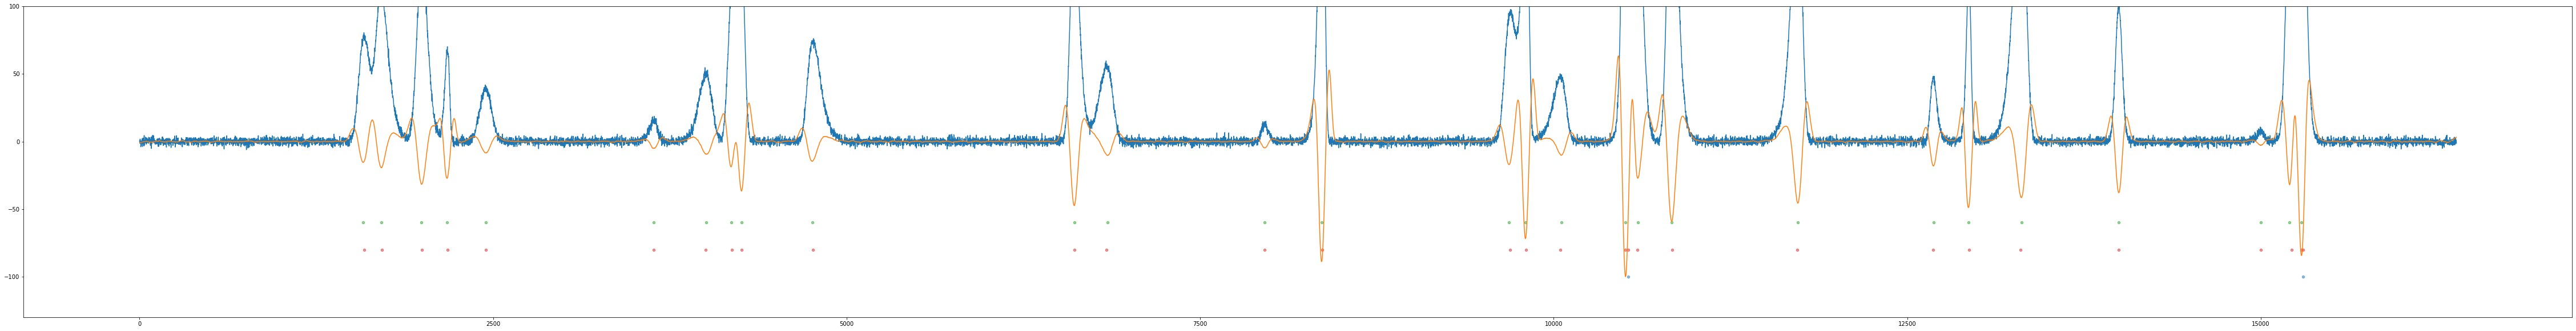

In [13]:
plt.figure(figsize=(80, 10)) # plot very big, double click to zoom in a bit

x = data['chromatogram']
plt.plot(x)
plt.plot(x_deriv * 100)

plt.scatter(loc * 16384, [-60] * len(loc), c ='C2', s=20, alpha=0.5)

plt.scatter(data['loc'] * 16384, [-80] * len(data['loc']), c ='C3', s=20, alpha=0.5)

plt.scatter(np.sort(data['loc'])[fn] * 16384, [-100] * len(data['loc'][fn]), s=20, alpha=0.5)

plt.scatter(np.sort(loc)[fp] * 16384, [-120] * len(loc[fp]), s=20, alpha=0.5)

plt.ylim(-130, 100)